In [ ]:
#!/usr/bin/env python
# coding: utf-8

import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import os

class BenchmarkLogger:
    def __init__(self, log_dir="logs", run_name="turyn_run"):
        os.makedirs(log_dir, exist_ok=True)
        self.log_path = os.path.join(log_dir, f"{run_name}.csv")
        self.columns = ["generation", "best_error", "valid_count", "sampled_count", "loss"]
        self.df = pd.DataFrame(columns=self.columns)
        self.current_gen = 0

    def log_generation(self, best_error, valid_count, sampled_count, loss):
        entry = {
            "generation": self.current_gen,
            "best_error": best_error,
            "valid_count": valid_count,
            "sampled_count": sampled_count,
            "loss": loss
        }
        self.df = pd.concat([self.df, pd.DataFrame([entry])], ignore_index=True)
        self.df.to_csv(self.log_path, index=False)
        self.current_gen += 1

    def plot_metrics(self):
        if self.df.empty:
            print("No benchmarking data to plot.")
            return

        fig, axs = plt.subplots(3, 1, figsize=(10, 12))

        axs[0].plot(self.df["generation"], self.df["best_error"], marker='o')
        axs[0].set_title("Best Turyn Error per Generation")
        axs[0].set_xlabel("Generation")
        axs[0].set_ylabel("Best Error")

        axs[1].plot(self.df["generation"], self.df["valid_count"] / self.df["sampled_count"], marker='o')
        axs[1].set_title("Valid Rate per Generation")
        axs[1].set_xlabel("Generation")
        axs[1].set_ylabel("Valid Rate")

        axs[2].plot(self.df["generation"], self.df["loss"], marker='o')
        axs[2].set_title("Transformer Loss per Generation")
        axs[2].set_xlabel("Generation")
        axs[2].set_ylabel("Loss")

        plt.tight_layout()
        plt.show()

# Now initialize it:
benchmark_logger = BenchmarkLogger(run_name="r17_test")

In [ ]:
########################################
# 1. Utility: Checking and Scoring Turyn Sequences
########################################

def npaf(seq, s):
    """
    Non-periodic autocorrelation function for shift s.
    seq is a list of +1/-1, length r.
    """
    return sum(seq[i] * seq[i+s] for i in range(len(seq)-s))

def turyn_error(X, Y, Z, W):
    """
    Sum of absolute values of partial sums of NPAF at each s.
    We want this = 0 for a valid Turyn 4-tuple.
    """
    r = len(X)
    total_err = 0
    for s in range(1, r):
        val = npaf(X, s) + npaf(Y, s) + npaf(Z, s) + npaf(W, s)
        total_err += abs(val)
    return total_err

def calculate_diversity(solutions):
    """
    Calculate diversity as the average Hamming distance between all pairs of solutions.
    """
    def hamming_distance(seq1, seq2):
        return sum(x != y for x, y in zip(seq1, seq2))

    flattened_solutions = [
        tuple(np.concatenate([X, Y, Z, W])) for _, (X, Y, Z, W) in solutions
    ]
    n = len(flattened_solutions)
    if n < 2:
        return 0  # No diversity if only one solution

    total_distance = 0
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            total_distance += hamming_distance(flattened_solutions[i], flattened_solutions[j])
            count += 1

    return total_distance / count

In [3]:
########################################
# 2. Local Search Step
########################################

def local_search_4tuple(X, Y, Z, W, max_iter=1000):
    """
    Simple local search: tries random single flips in each sequence
    to reduce or fix the 'turyn_error'.
    """
    current_err = turyn_error(X, Y, Z, W)
    if current_err == 0:
        return (X, Y, Z, W)  # already good

    r = len(X)
    sequences = [X, Y, Z, W]
    improved = True
    iteration = 0

    while improved and iteration < max_iter and current_err > 0:
        improved = False

        # Try flipping random bits in any of the 4 sequences
        for _ in range(10*r):  # attempt multiple tries
            seq_idx = np.random.randint(0, 4)
            pos_idx = np.random.randint(0, r)
            sequences[seq_idx][pos_idx] *= -1  # flip

            new_err = turyn_error(*sequences)
            if new_err < current_err:
                current_err = new_err
                improved = True
            else:
                # revert flip if it didn't help
                sequences[seq_idx][pos_idx] *= -1

        iteration += 1

    # Return final
    return (sequences[0], sequences[1], sequences[2], sequences[3])

In [4]:
########################################
# 3. Tokenization Helpers
########################################

def sequences_to_tokens(X, Y, Z, W, chunk_size=6):
    """
    Flatten the 4 sequences, each length r.
    Then group bits in 'chunk_size' chunks.
    Return a list of integers in [0, 2^(chunk_size)-1].
    This is one simple way; you can use BPE or other too.
    """
    # Flatten: +1 => 1, -1 => 0
    flattened = []
    for seq in [X, Y, Z, W]:
        for val in seq:
            flattened.append(1 if val == 1 else 0)

    # chunk them
    vocab = []
    cur_val = 0
    bit_count = 0
    tokens = []
    for bit in flattened:
        cur_val = (cur_val << 1) | bit
        bit_count += 1
        if bit_count == chunk_size:
            tokens.append(cur_val)
            cur_val = 0
            bit_count = 0
    # if leftover bits exist, pad or store them
    if bit_count > 0:
        tokens.append(cur_val)
    # add special token for "end"
    # tokens.append(VOCAB_END) # optional

    return tokens

def tokens_to_sequences(tokens, r, chunk_size=6):
    """
    Inverse of sequences_to_tokens. Reconstruct the 4 sequences (X,Y,Z,W).
    Return None if length doesn't match 4*r bits.
    """
    total_bits = 4*r
    out_bits = []
    bits_per_token = chunk_size
    for t in tokens:
        for i in reversed(range(bits_per_token)):
            bit = (t >> i) & 1
            out_bits.append(bit)

    if len(out_bits) < total_bits:
        # not enough bits => skip or pad?
        return None
    out_bits = out_bits[:total_bits]

    # Convert bits to +1/-1
    final_4tuples = []
    idx = 0
    for _ in range(4):
        seq = []
        for __ in range(r):
            seq.append(+1 if out_bits[idx] == 1 else -1)
            idx += 1
        final_4tuples.append(seq)
    return tuple(final_4tuples)

In [5]:
########################################
# 4. Building a Tiny Transformer (Makemore-style)
########################################

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, n_head=4, n_layer=2, block_size=200):
        super().__init__()
        self.d_model = d_model
        self.block_size = block_size
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(block_size, d_model)
        self.layers = nn.ModuleList([
            Block(d_model, n_head) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None):
        b, t = idx.shape
        # embed tokens and positions
        tok_emb = self.token_embed(idx)  # (B,T,d_model)
        pos = torch.arange(0, t, dtype=torch.long, device=idx.device)
        pos_emb = self.pos_embed(pos)[None, :, :]  # (1,T,d_model)
        x = tok_emb + pos_emb
        for layer in self.layers:
            x = layer(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B,T,vocab_size)

        if targets is not None:
            # shift the logits to compare with next token
            logits_shifted = logits[:, :-1, :].contiguous()
            targets_shifted = targets[:, 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits_shifted.view(-1, logits_shifted.size(-1)),
                            targets_shifted.view(-1))
            return logits, loss
        else:
            return logits, None

    def generate(self, idx, max_new_tokens):
        # auto-regressive sampling
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]  # last time step
            probs = torch.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_idx], dim=1)
        return idx

class Block(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.sa = MultiHeadAttention(d_model, n_head)
        self.ff = FeedFwd(d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.head_size = d_model // n_head
        self.key = nn.Linear(d_model, d_model)
        self.query = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.register_buffer("tril", torch.tril(torch.ones(1024,1024))) # block_size max
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x).view(B,T,self.n_head,self.head_size).transpose(1,2)
        q = self.query(x).view(B,T,self.n_head,self.head_size).transpose(1,2)
        v = self.value(x).view(B,T,self.n_head,self.head_size).transpose(1,2)
        # compute attention
        att = q @ k.transpose(-2,-1) * (1.0/self.head_size**0.5)
        mask = self.tril[:T,:T]
        att = att.masked_fill(mask==0, float('-inf'))
        att = torch.softmax(att, dim=-1)
        out = att @ v
        out = out.transpose(1,2).contiguous().view(B,T,C)
        out = self.out(out)
        return out

class FeedFwd(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
########################################
# 5. PatternBoost Loop
########################################

def patternboost_turyn(r=13, chunk_size=6, n_generation=10, local_iters=1000,
                       sample_per_generation=2000, vocab_size=None):
    """
    r: length of each sequence
    chunk_size: for tokenization
    n_generation: how many patternboost loops
    sample_per_generation: how many new tokens to sample from transformer each loop
    """
    # We'll set vocab_size = 2^(chunk_size) if not specified
    if vocab_size is None:
        vocab_size = 2**chunk_size

    # Step A: Initialize an empty list of good solutions
    best_solutions = []

    # Step B: Start by random local searches
    for _ in range(2000):
        # random start
        X = [random.choice([1,-1]) for __ in range(r)]
        Y = [random.choice([1,-1]) for __ in range(r)]
        Z = [random.choice([1,-1]) for __ in range(r)]
        W = [random.choice([1,-1]) for __ in range(r)]
        X, Y, Z, W = local_search_4tuple(X, Y, Z, W, max_iter=200)
        err = turyn_error(X, Y, Z, W)
        best_solutions.append( (err,(X,Y,Z,W)) )

    # sort by err, keep top
    best_solutions.sort(key=lambda x: x[0])
    best_solutions = best_solutions[:500]  # keep top 500
    print("Initial best solutions loaded. E.g. best error so far=", best_solutions[0][0])

    # Build the transformer model
    block_size = 4*r // chunk_size + 2  # some upper bound
    model = TinyTransformer(vocab_size=vocab_size, d_model=64,
                            n_head=4, n_layer=2, block_size=block_size)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    # We'll do repeated loops of train => sample => local search => retain best
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

    def build_dataset(pairs):
        # pairs is list of (err, (X,Y,Z,W))
        # convert to tokens, then store in a long tensor with shifting
        all_ids = []
        for (er, (X, Y, Z, W)) in pairs:
            tokens = sequences_to_tokens(X, Y, Z, W, chunk_size=chunk_size)
            # Add a special "end" or just slice
            if len(tokens) > block_size-1:
                tokens = tokens[:block_size-1]
            # in typical GPT: we add "start" token or we just let index=0 be start
            # for simplicity, no special start token. We'll add an "end=0" at the end
            tokens.append(0) # end
            all_ids.append(tokens)

        # pad to block_size
        Xmb = []
        for seq in all_ids:
            if len(seq) < block_size:
                seq = seq + [0]*(block_size - len(seq))
            Xmb.append(seq)
        Xmb = torch.tensor(Xmb, dtype=torch.long)
        return Xmb

    for gen_idx in range(n_generation):
        # 1. Build dataset from best_solutions
        batch_data = build_dataset(best_solutions)
        # small random shuffle
        perm = torch.randperm(batch_data.size(0))
        batch_data = batch_data[perm]
        # 2. Train for some epochs
        n_epochs = 5
        for ep in range(n_epochs):
            # do minibatches
            bs = 32
            for start in range(0, batch_data.size(0), bs):
                end = start+bs
                xb = batch_data[start:end].to(device)
                logits, loss = model(xb, targets=xb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if ep == n_epochs-1:
                print(f"Generation {gen_idx} epoch {ep} - loss {loss.item():.4f}")

        # 3. Sample from the model
        new_candidates = []
        to_sample = sample_per_generation
        prompt = torch.zeros((1,1), dtype=torch.long, device=device) # single token prompt=0
        with torch.no_grad():
            for sp in range(to_sample):
                # generate up to block_size tokens
                out = model.generate(prompt, max_new_tokens=block_size-1)
                out_seq = out[0,1:].cpu().numpy().tolist()  # skip the first token
                # decode
                s4 = tokens_to_sequences(out_seq, r, chunk_size=chunk_size)
                if s4 is not None:
                    # local search fix
                    Xf, Yf, Zf, Wf = local_search_4tuple(*s4, max_iter=200)
                    err_fix = turyn_error(Xf, Yf, Zf, Wf)
                    new_candidates.append( (err_fix, (Xf,Yf,Zf,Wf)) )

        # 4. Merge with current best_solutions, keep top 500
        merged = best_solutions + new_candidates
        merged.sort(key=lambda x:x[0])
        best_solutions = merged[:500]

        valid_count = len([err for err, _ in new_candidates if err == 0])

        benchmark_logger.log_generation(
            best_error=best_solutions[0][0],
            valid_count=valid_count,
            sampled_count=len(new_candidates),
            loss=loss.item()
        )

        print(f"After generation {gen_idx}, best error = {best_solutions[0][0]}")

        if best_solutions[0][0] == 0:
            print("Valid Turyn 4-tuple found. Stopping early.")
            break

    return best_solutions

Initial best solutions loaded. E.g. best error so far= 0
Generation 0 epoch 4 - loss 3.4652
After generation 0, best error = 0
Valid Turyn 4-tuple found. Stopping early.
Done. Best solution found error= 0
Here is a valid Turyn 4-tuple we found:
X = [-1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1]
Y = [1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1]
Z = [1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1]
W = [1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1]


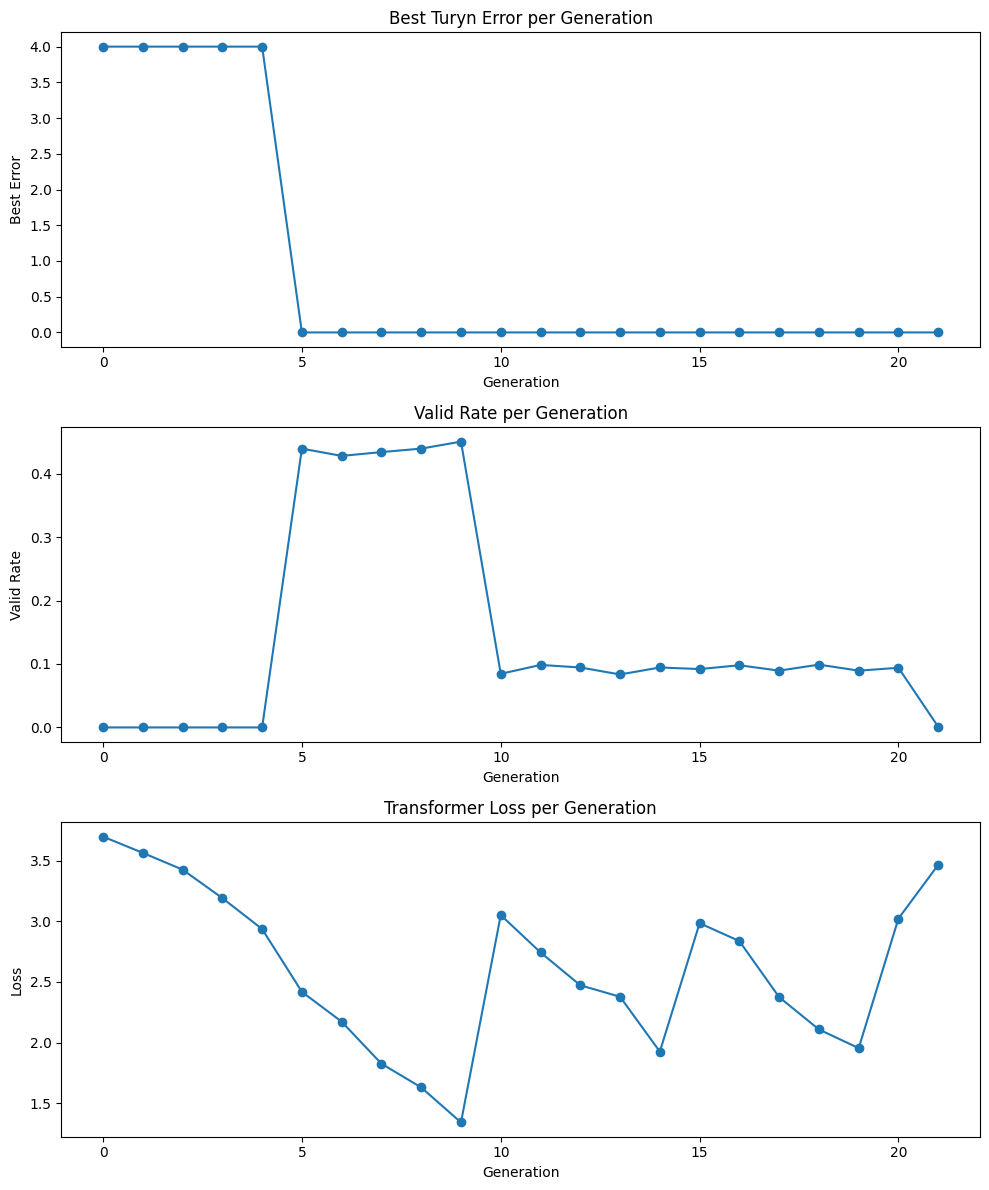

In [13]:
if __name__ == "__main__":
    final_solutions = patternboost_turyn(r=13, n_generation=5)
    print("Done. Best solution found error=", final_solutions[0][0])
    if final_solutions[0][0] == 0:
      (X, Y, Z, W) = final_solutions[0][1]  # the 4-tuple is stored in the second item
      print("Here is a valid Turyn 4-tuple we found:")
      print("X =", X)
      print("Y =", Y)
      print("Z =", Z)
      print("W =", W)
    benchmark_logger.plot_metrics()
    # If final_solutions[0][0] == 0, we found a valid Turyn 4-tuple.